In [ ]:
%%capture
import sys

!python -m pip install TextBlob
!python -m pip install newspaper3k
!python -m pip install preprocessor
!python -m pip install Twython
!python -m pip install tweepy
!python -m pip install os
!python -m pip install nltk
!python -m pip install tensorflow
!python -m pip install contractions
!python -m pip install autocorrect
!python -m pip install betterspy
!python -m pip install tensorflow
!python -m pip install cvxopt import matrix, solvers

In [ ]:
# Load packages
import os
import time

from textblob import TextBlob
from newspaper import Article
import nltk
import re

import requests
import preprocessor as pre
import csv
import json
import string
from string import punctuation
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from contractions import contractions_dict
from autocorrect import Speller
import seaborn as sns
import pylab as pl
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

import numpy as np
import pandas as pd
import sklearn
import tensorflow

import tweepy
from tweepy import OAuthHandler
from twython import Twython

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# Data Setup

In [ ]:
# Handling directories
from google.colab import drive
drive.mount('/content/drive')
df_movie = pd.read_csv('/content/drive/My Drive/Spring 2022/CS4824/finalproj/movies/movie.csv')

#Append the directory to your python path
prefix = '/content/drive/My Drive/'
# modify customized_path
customized_path = 'Spring 2022/CS4824/finalproj/'
data_folder = 'movies/'
sys_path = prefix + customized_path + data_folder
sys.path.append(sys_path)
print(sys.path)

data_filename = os.path.join(sys_path, 'movie.csv')
print('Path to training data: {}'.format(data_filename))
#fn_test = os.path.join(sys_path, './')
#print('Path to testing data: {}'.format(fn_test))

Mounted at /content/drive
['', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/My Drive/Spring 2022/CS4824/finalproj/movies/']
Path to training data: /content/drive/My Drive/Spring 2022/CS4824/finalproj/movies/movie.csv


In [ ]:
#Loading in and splitting training and test data
df_orig = pd.read_csv(data_filename)
df_orig = df_orig.drop(labels=range(20001, 40000))

print(df_orig)

                                                    text  label
0      I grew up (b. 1965) watching and loving the Th...      0
1      When I put this movie in my DVD player, and sa...      0
2      Why do people who do not know what a particula...      0
3      Even though I have great interest in Biblical ...      0
4      Im a die hard Dads Army fan and nothing will e...      1
...                                                  ...    ...
19996  "White Noise" had potential to be one of the m...      0
19997  The Five Deadly Venoms is a great kung-fu acti...      1
19998  Ali G Indahouse has got to be one of the funni...      1
19999  I found myself at sixes and sevens while watch...      1
20000  Christopher Lambert is annoying and disappoint...      0

[20001 rows x 2 columns]


# Text Preprocessing

In [ ]:
def lowercase(text):
  """
    Converts text to be completely lowercase.

    Argument: String of text.
    Returns: Completely lowercase version of input text.
  """
  return text.lower()
  
def remove_stopwords(text):
  """
    Removes all stopwords from the text.
    Note: Refers to nltk's default English stopword list.

    Argument: String of text.
    Returns: Input text, now free of stopwords.
  """
  #Treat text as sentence
  stopword_list = stopwords.words('english')
  return ' '.join([word for word in nltk.word_tokenize(text) if not word in stopword_list])

def lemmatize(text_tagged):
  """
    Normalizes all words in the text
    Note: Utilizes nltk's WordNet's lemmatizer to derive lemmatizations.

    Argument: A list of tuples: [(<word>, <part of speech retag>),...]
    Returns: Lemmatized form of text
  """
  lemmatizer = WordNetLemmatizer()
  lemmatized = ""
  for word, pos in text_tagged:
    if not pos:
      lemmatized = lemmatized + " " + word
    else:
      lemmatized = lemmatized + " " + lemmatizer.lemmatize(word, pos=pos)

  return lemmatized

def retag(text_tagged):
  """
    Rewrites the part of speech tags for each word into a form
    interpretable by WordNet.

    Argument: A list of tuples: [(<word>, <part of speech tag>),...]
    Returns: Lemmatized form of text
  """
  pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}
  retagged = []
  for word, tag in text_tagged:
      retagged.append(tuple([word, pos_dict.get(tag[0])]))

  return retagged

def spellcheck(text):
  corrections = [Speller.spell(word) for word in nltk.word_tokenize(text)]
  return ' '.join(corrections)


#All functions combined
def preprocessing3(text):
  """
    Aggregation of preprocessing functions into one.
    Note: Additionally uses re's sub() function for convenient cleaning.

    Argument: Text, as a string.
    Returns: Preprocessed text.
  """
  lower = lowercase(text)
  cleaned = re.sub('[^A-Za-z]+', ' ', lower)
  stopwordfree = remove_stopwords(cleaned)
  tokenized = word_tokenize(stopwordfree)
  pos = nltk.pos_tag(tokenized)
  posretagged = retag(pos)
  lemmatized = lemmatize(posretagged)
  tokenized2 = word_tokenize(lemmatized)
  
  #return tokenized2 #final, option1
  return lemmatized #final, option2

In [ ]:
extext = df_orig.iloc[50]['text']

print(extext)
print(preprocessing3(extext))

When this first came out, my dad brought it home- we were amazed by it- It was so different from anything we had seen before. I was looking for a specific movie last night, and I found "The Mind's Eye" again. The box is falling apart, and I am surprised that the tape still works! Although it is not 'Finding Nemo' quality graphics, it is still very good. They should sell this again- it is a landmark for computer animation imagery. Highly recommended!<br /><br />This is what it is:<br /><br />"The Mind's Eye" is a spectacular odyssey through time. Your journey begins at the dawn of creation and moves through the rise of man and technology. Travel in the world of abstraction and on into the future with breathtaking computer animation imagery.<br /><br />"The Mind's Eye" joins the imaginations of over 300 of the world's most talented computer animation artists with a powerful, original music soundtrack. This unique collaboration takes you on an incredible voyage into "The Mind's Eye."
 fir

In [ ]:
df_labels = df_orig['label']
df_text = df_orig['text'].apply(preprocessing3, 'expand')

print(df_text.head())

0     grow b watch loving thunderbird mat school wa...
1     put movie dvd player sit coke chip expectatio...
2     people know particular time past like feel ne...
3     even though great interest biblical movie bor...
4     im die hard dad army fan nothing ever change ...
Name: text, dtype: object


# Training and Test Split

In [ ]:
data_proc = {'text': df_text, 'label': df_labels}
df_proc = pd.DataFrame(data=data_proc)
print(df_proc)

from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df_proc, test_size=0.2)

train_data = train_df['text']
train_labs = train_df['label']
test_data = test_df['text']
test_labs = test_df['label']

                                                    text  label
0       grow b watch loving thunderbird mat school wa...      0
1       put movie dvd player sit coke chip expectatio...      0
2       people know particular time past like feel ne...      0
3       even though great interest biblical movie bor...      0
4       im die hard dad army fan nothing ever change ...      1
...                                                  ...    ...
19996   white noise potential one talk movie since ex...      0
19997   five deadly venom great kung fu action movie ...      1
19998   ali g indahouse get one funny film see long t...      1
19999   find six sevens watch one altman touch zoom e...      1
20000   christopher lambert annoy disappointing portr...      0

[20001 rows x 2 columns]


# Text Vectorization

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=100)
vectorizer.fit(df_proc['text'])

train_data_tfidf = vectorizer.transform(train_data)
test_data_tfidf = vectorizer.transform(test_data)

In [ ]:
print(len(vectorizer.vocabulary_))
print(type(train_data_tfidf))
print(train_data_tfidf.shape)
print(train_data_tfidf[0])
print(np.max(train_data_tfidf))

Xtrain = train_data_tfidf.toarray()
Xtest = test_data_tfidf.toarray()
ytrain = train_labs.to_numpy()
ytest = train_labs.to_numpy()

print(Xtrain.shape)
print(Xtrain)
print(ytrain.shape)
print(ytrain.T)

100
<class 'scipy.sparse.csr.csr_matrix'>
(16000, 100)
  (0, 69)	0.21681225156499656
  (0, 68)	0.2979008478633487
  (0, 60)	0.3260887380135827
  (0, 49)	0.36349700929664086
  (0, 45)	0.21003997083141449
  (0, 33)	0.5871664298090341
  (0, 21)	0.3846093656355557
  (0, 0)	0.2982918400000042
1.0
(16000, 100)
[[0.29829184 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.16220945 0.17893429 0.         ... 0.21052812 0.18046027 0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.06890658 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
(16000,)
[1 1 0 ... 0 0 0]


## Feature Selection

In [ ]:
print(np.count_nonzero(Xtrain[1,:])/len(Xtrain[1,:]))
print(train_data_tfidf[1,:].getnnz()/80506)

print(train_data_tfidf[1035,:])
print(train_data_tfidf[:,1])
#print(np.dot(train_data_tfidf[1,:], train_data_tfidf[5,:]))

0.2
0.0002484286885449532
  (0, 19)	0.16971985340867474
  (0, 24)	0.12450247065351769
  (0, 32)	0.15224235339313433
  (0, 38)	0.21362956916794532
  (0, 47)	0.21319884756892082
  (0, 49)	0.1168536961991283
  (0, 50)	0.18497916166364076
  (0, 52)	0.25152037117819703
  (0, 58)	0.24519629534513074
  (0, 69)	0.13939764195390983
  (0, 73)	0.2290929342892216
  (0, 76)	0.6746368822464701
  (0, 81)	0.1769474968978138
  (0, 86)	0.21495644101729547
  (0, 95)	0.2561299424667805
  (2, 0)	0.178934289615488
  (5, 0)	0.16451549467852966
  (8, 0)	0.08352757110784775
  (10, 0)	0.07767319552951645
  (14, 0)	0.13692382661913843
  (17, 0)	0.1824245561138881
  (20, 0)	0.2665784200284169
  (41, 0)	0.08096374815628754
  (45, 0)	0.11734274997012285
  (47, 0)	0.06302516275819435
  (51, 0)	0.1798872557995854
  (55, 0)	0.16244619196123017
  (68, 0)	0.3589177509654532
  (80, 0)	0.5088407995201546
  (81, 0)	0.19387595773850608
  (89, 0)	0.06911268523127355
  (93, 0)	0.09613944568948257
  (103, 0)	0.1615111177664338

In [ ]:
import math 

#print(train_data[0])

def txf(sentence):
  word_dict = {}
  words = word_tokenize(sentence);
  
  for word in words:
    word_dict[word] = word_dict.get(word, 0) + 1
  return word_dict

print(txf(extext))
print(len(df_orig))

class TFIDF:
  def __init__(self):
    self.word_index = {}
    self.index_word = {}
    self.idf_dict = {}
  
  def fit(self, data):
    text_list = data
    text_num = len(text_list)

    global_tf = {}
    for text in text_list:
      wordset = set()
      text_tf = txf(text)

      for word in text_tf:
        if word not in wordset:
          global_tf[word] = global_tf.get(word,0) + 1
          wordset.add(word)

    for word, freq in global_tf.items():
      idf = math.log((1+len(data)) / (1+freq))
      self.idf_dict[word] = idf

    text_words = list(global_tf.keys())
    for i in range(len(text_words)):
      word = text_words[i]
      self.word_index[word] = i
      self.index_word[i] = word

    print(type(global_tf.items()))

  def transform(self, data):
    text_vects = []
    text_list = data

    for text in text_list:
      text_vects.append(self.transformtext(data, text))

    return np.matrix(text_vects)

  def transformtext(self, data, text):
    text_list = data
    text_tokenized = word_tokenize(text)
    
    word_vector = np.zeros(len(self.word_index))
    text_tfidf = self.text_tfidf(text)

    for word in text_tokenized:
      if word in self.word_index:
        word_index = self.word_index[word]
        word_vector[word_index] = text_tfidf[word]

    return word_vector

  def text_tfidf(self, text):
    text_tfidf = {}
    text_tf = txf(text)
    num_words = sum(text_tf.values())
    
    average_freq = {k:(float(v)/num_words) for k, v in text_tf.items()}

    for term, tf in average_freq.items():
      text_tfidf[term] = tf*self.idf_dict.get(term, 0)

    return text_tfidf

{'When': 1, 'this': 2, 'first': 1, 'came': 1, 'out': 1, ',': 5, 'my': 1, 'dad': 1, 'brought': 1, 'it': 5, 'home-': 1, 'we': 2, 'were': 1, 'amazed': 1, 'by': 1, 'it-': 1, 'It': 1, 'was': 2, 'so': 1, 'different': 1, 'from': 1, 'anything': 1, 'had': 1, 'seen': 1, 'before': 1, '.': 8, 'I': 3, 'looking': 1, 'for': 2, 'a': 4, 'specific': 1, 'movie': 1, 'last': 1, 'night': 1, 'and': 5, 'found': 1, '``': 2, 'The': 5, 'Mind': 4, "'s": 5, 'Eye': 4, "''": 6, 'again': 1, 'box': 1, 'is': 7, 'falling': 1, 'apart': 1, 'am': 1, 'surprised': 1, 'that': 1, 'the': 7, 'tape': 1, 'still': 2, 'works': 1, '!': 2, 'Although': 1, 'not': 1, "'Finding": 1, 'Nemo': 1, "'": 1, 'quality': 1, 'graphics': 1, 'very': 1, 'good': 1, 'They': 1, 'should': 1, 'sell': 1, 'again-': 1, 'landmark': 1, 'computer': 3, 'animation': 3, 'imagery': 1, 'Highly': 1, 'recommended': 1, '<': 6, 'br': 6, '/': 6, '>': 6, 'This': 2, 'what': 1, ':': 1, 'spectacular': 1, 'odyssey': 1, 'through': 2, 'time': 1, 'Your': 1, 'journey': 1, 'begins'

In [ ]:
#test = TFIDF()
#test.fit(train_data)
#test.transform(train_data)
#print(test.index_word)

# Machine Learning Algorithms


## Multinomial Naive Bayes

## SVM

In [ ]:
def accuracy(data, predictions):
  data = data.to_numpy()
  correct = 0

  for i in range(len(predictions)):
    if (float(data[i]) == 1.0 and predictions[i][0] == 1.0) or (float(data[i]) == 0.0 and predictions[i][0] == 0.0):
      correct += 1

  return float(correct/len(predictions))

In [ ]:
#Implementation of SVM class inspired by 

from cvxopt import matrix, solvers

class SVM():
  def __init__(self, C, kernel='lin', degree=None, intercept=None, sigma=None):
    #C, the stretch parameter
    self.C = C
    self.kernel = self.kernel_lin

    if kernel == 'poly':
      self.kernel = self.kernel_poly
      self.degree = degree
    elif kernel == 'gauss':
      self.sigma = sigma
      self.kernel = self.kernel_gauss

  def fit(self, X, y):
    m, n = Xtrain.shape
    y = y.reshape(-1, 1)
    y = y.astype('float')

    K = self.kernel(X, X)

    self.labels = np.unique(y)
    print(self.labels)
    
    recode = y == self.labels[0]
    y[recode] = 1       
    y[~recode] = -1
    y = y * 1.

    assert(X.shape[0] == y.shape[0])

    P = matrix(np.matmul(y,y.T)*K)
    q = matrix(np.ones((m, 1))*-1)
    A = matrix(y.reshape(1, -1))
    b = matrix(np.zeros(1))
    G = matrix(np.vstack((np.eye(m) * -1, np.eye(m))))        
    h = matrix(np.hstack((np.zeros(m), np.ones(m) * self.C)))

    sol = solvers.qp(P,q,G,h,A,b)
    alpha = np.array(sol['x'])
    idx = (alpha > 1e-4).flatten()

    self.sv = X[idx]
    self.sv_y = y[idx]
    self.alpha = alpha[idx]

    b = self.sv_y - np.sum(self.kernel(self.sv, self.sv) * self.alpha * self.sv_y, axis = 0)
    
    self.b = np.sum(b)/b.size
    self.w = np.sum(self.alpha * self.sv_y * self.sv, axis=0)

  def kernel_lin(self, u, v):
    return np.dot(u, v.T)

  def kernel_poly(self, u, v):
    return (np.dot(u,v.T)+1)**self.degree

  def kernel_gauss(self, u, v):
    return np.exp(-(np.linalg.norm(u - v) ** 2)/(2*self.sigma **2))

  def predict(self, Xtest):
        if self.w is None:
            print("No model constructed.")
            return
        else:
            ypred = np.dot(self.w, Xtest.T) + self.b

        ypred = np.sign(ypred)
        ypred = ypred.reshape(-1, 1)
        recode = ypred == 1.
        ypred[recode] = self.labels[0]
        ypred[~recode] = self.labels[1]

        return ypred

  

In [ ]:
models_forC = list()
models_forkernel = list()

In [ ]:
base = SVM(0.5)
print(Xtrain.shape, ytrain.shape)
print(type(Xtrain), type(ytrain))
base.fit(Xtrain, ytrain)

(16000, 100) (16000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[0. 1.]
     pcost       dcost       gap    pres   dres
 0: -8.2145e+03 -2.7075e+04  3e+05  8e+00  6e-14
 1: -3.9896e+03 -2.3216e+04  5e+04  9e-01  6e-14
 2: -3.4618e+03 -1.1533e+04  1e+04  8e-02  3e-14
 3: -3.9680e+03 -5.4397e+03  2e+03  1e-02  4e-14
 4: -4.3828e+03 -4.9406e+03  6e+02  4e-03  4e-14
 5: -4.5068e+03 -4.7914e+03  3e+02  2e-03  4e-14
 6: -4.5703e+03 -4.7131e+03  1e+02  8e-04  5e-14
 7: -4.6014e+03 -4.6749e+03  8e+01  3e-04  5e-14
 8: -4.6158e+03 -4.6575e+03  4e+01  2e-04  5e-14
 9: -4.6283e+03 -4.6426e+03  1e+01  5e-05  5e-14
10: -4.6323e+03 -4.6380e+03  6e+00  1e-05  5e-14
11: -4.6340e+03 -4.6360e+03  2e+00  3e-06  5e-14
12: -4.6347e+03 -4.6353e+03  7e-01  1e-06  5e-14
13: -4.6349e+03 -4.6351e+03  2e-01  1e-07  5e-14
14: -4.6350e+03 -4.6350e+03  8e-03  5e-09  6e-14
15: -4.6350e+03 -4.6350e+03  2e-03  7e-10  5e-14
Optimal solution found.


In [ ]:
base_model = base.w
base_pred = base.predict(Xtest)

print(accuracy(test_labs, base_pred))

0.7438140464883779


In [ ]:
poly = SVM(0.5, kernel='poly', degree=2, intercept=1)
poly.fit(Xtrain, ytrain)

[0. 1.]
     pcost       dcost       gap    pres   dres
 0: -6.5309e+03 -2.1538e+04  2e+05  6e+00  3e-13
 1: -3.5924e+03 -1.7710e+04  3e+04  7e-01  3e-13
 2: -3.3223e+03 -1.0440e+04  1e+04  2e-01  2e-13
 3: -3.5466e+03 -4.9461e+03  2e+03  2e-02  2e-13
 4: -3.8457e+03 -4.4530e+03  7e+02  8e-03  2e-13
 5: -3.9433e+03 -4.3052e+03  4e+02  4e-03  2e-13
 6: -4.0357e+03 -4.1607e+03  1e+02  1e-03  2e-13
 7: -4.0733e+03 -4.1051e+03  3e+01  2e-04  3e-13
 8: -4.0846e+03 -4.0896e+03  5e+00  2e-05  3e-13
 9: -4.0866e+03 -4.0870e+03  5e-01  1e-06  3e-13
10: -4.0867e+03 -4.0868e+03  2e-02  6e-08  3e-13
11: -4.0868e+03 -4.0868e+03  5e-04  1e-09  3e-13
Optimal solution found.


TypeError: ignored

In [ ]:
poly_pred = poly.predict(Xtest)
print(accuracy(test_labs, poly_pred))

0.7373156710822294


In [ ]:
gauss = SVM(0.5, kernel='gauss', sigma=0.2)
gauss.fit(Xtrain, ytrain)

models_forkernel.append(poly)
models_forkernel.append(gauss)

[0. 1.]
     pcost       dcost       gap    pres   dres
 0: -1.2000e+04 -1.6008e+04  6e+04  4e+00  8e-12
 1: -6.5141e+03 -1.3114e+04  7e+03  2e-12  8e-12
 2: -7.6911e+03 -8.0510e+03  4e+02  2e-13  8e-13
 3: -7.9860e+03 -8.0014e+03  2e+01  8e-14  3e-12
 4: -7.9877e+03 -7.9897e+03  2e+00  3e-13  3e-12
 5: -7.9890e+03 -7.9890e+03  2e-02  4e-13  5e-12
 6: -7.9890e+03 -7.9890e+03  2e-04  1e-13  5e-12
Optimal solution found.


In [ ]:
lin1 = SVM(0.1)
lin2 = SVM(1,0)
lin3 = SVM(2.5)
lin4 = SVM(4.0)
lin1.fit(Xtrain, ytrain)
lin2.fit(Xtrain,ytrain)
lin3.fit(Xtrain,ytrain)
lin4.fit(Xtrain,ytrain)
models_forC.append(lin1)
models_forC.append(lin2)
models_forC.append(lin3)
models_forC.append(lin4)

[0. 1.]
     pcost       dcost       gap    pres   dres
 0: -6.0294e+03 -4.8352e+03  2e+05  4e+01  4e-14
 1: -9.7336e+02 -4.6553e+03  1e+04  2e+00  4e-14
 2: -7.2841e+02 -2.8531e+03  3e+03  1e-01  9e-15
 3: -8.2786e+02 -1.1331e+03  3e+02  1e-02  8e-15
 4: -9.4042e+02 -1.0194e+03  8e+01  3e-03  9e-15
 5: -9.6349e+02 -9.9709e+02  3e+01  9e-04  1e-14
 6: -9.7431e+02 -9.8579e+02  1e+01  3e-04  1e-14
 7: -9.7707e+02 -9.8292e+02  6e+00  1e-04  1e-14
 8: -9.7900e+02 -9.8087e+02  2e+00  3e-05  1e-14
 9: -9.7958e+02 -9.8027e+02  7e-01  8e-06  1e-14
10: -9.7983e+02 -9.8000e+02  2e-01  1e-06  1e-14
11: -9.7990e+02 -9.7993e+02  3e-02  2e-07  1e-14
12: -9.7991e+02 -9.7992e+02  4e-03  2e-08  1e-14
13: -9.7991e+02 -9.7991e+02  2e-04  5e-10  1e-14
Optimal solution found.
[0. 1.]
     pcost       dcost       gap    pres   dres
 0: -1.0940e+04 -6.1510e+04  4e+05  4e+00  8e-14
 1: -7.2042e+03 -4.7920e+04  8e+04  6e-01  8e-14
 2: -6.7427e+03 -1.8271e+04  1e+04  2e-02  7e-14
 3: -8.0409e+03 -1.0566e+04  3e

In [ ]:
models_forC.append(base)
models_forkernel.append(base)
print(models_forC)
print(models_forkernel)

[<__main__.SVM object at 0x7fed562d0fd0>, <__main__.SVM object at 0x7fed562d05d0>, <__main__.SVM object at 0x7fed562d0c10>, <__main__.SVM object at 0x7fed562d0dd0>, <__main__.SVM object at 0x7fed56246290>]
[<__main__.SVM object at 0x7fed61e78990>, <__main__.SVM object at 0x7fed562bbf50>, <__main__.SVM object at 0x7fed56246290>]


In [ ]:
acc_forC = []
acc_forK = []

acc_forC.append(accuracy(test_labs, lin1.predict(Xtest)))
acc_forC.append(accuracy(test_labs, base.predict(Xtest)))
acc_forC.append(accuracy(test_labs, lin2.predict(Xtest)))
acc_forC.append(accuracy(test_labs, lin3.predict(Xtest)))
acc_forC.append(accuracy(test_labs, lin4.predict(Xtest)))
print(acc_forC)

acc_forK.append(accuracy(test_labs, base.predict(Xtest)))
acc_forK.append(accuracy(test_labs, poly.predict(Xtest)))
acc_forK.append(accuracy(test_labs, gauss.predict(Xtest)))
xaxisK = ["Linear", "Polynomial", "Gaussian"]
print(acc_forK)


[0.7393151712071983, 0.7438140464883779, 0.7425643589102724, 0.7428142964258935, 0.7428142964258935]
[0.7438140464883779, 0.7373156710822294, 0.6830792301924519]


Text(0.5, 1.0, 'Distribution of TF-IDF Scores')

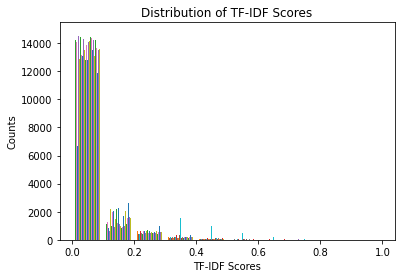

In [ ]:
import matplotlib.pyplot as plt
plt.hist(Xtrain)
plt.xlabel("TF-IDF Scores")
plt.ylabel("Counts")
plt.title("Distribution of TF-IDF Scores")

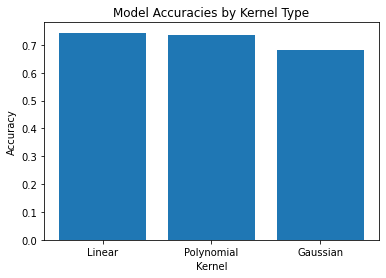

In [ ]:
plt.figure()
plt.bar(xaxisK, acc_forK)
plt.xlabel("Kernel")
plt.ylabel("Accuracy")
plt.title("Model Accuracies by Kernel Type")
plt.show()

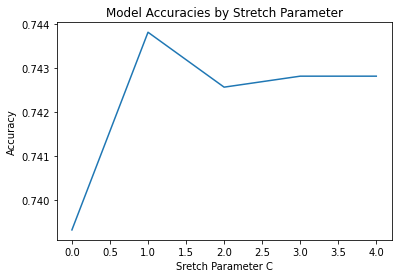

In [ ]:
plt.figure()
plt.plot(range(0,5), acc_forC)
plt.xlabel("Sretch Parameter C")
plt.ylabel("Accuracy")
plt.title("Model Accuracies by Stretch Parameter")
plt.show()

In [ ]:
print("Range of accuracies by C: ", max(acc_forC) - min(acc_forC))
print("Range of accuracies by kernel: ", max(acc_forK) - min(acc_forK))

Range of accuracies by C:  0.004498875281179648
Range of accuracies by kernel:  0.06073481629592603
